### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.functional as F
from sklearn.preprocessing import MinMaxScaler,normalize 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
sns.set()

#Changing directory to root of the project directory
os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd())

C:\Chethan\Mechanical\projects\E-Minor-Project


### Procedure involved,

**1. Data collection/generation**

Training data has to be collected by driving on a wide variety of roads and in a diverse set of lighting and weather conditions but due to the time limitations we were only able to  collect data by driving our vehicle about 5-6 km in a bitumen road.
The data was acquired using  Maruthi Suzuki Baleno as test vehicle.
 The camera was  placed at the middle position but this system has no dependencies on any particular vehicle model.
Data was collected in clear weather but it has to be collected in cloudy, foggy, snowy, and rainy weather, both day and night.

### Importing the data



In [2]:
df = pd.read_csv("data/data.csv",index_col=0)
print('Total number of images :',df.shape[0])

Total number of images : 3348


### Hisrogram of raw data

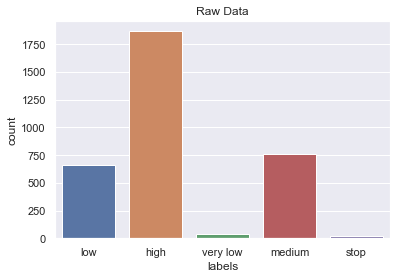

In [3]:
p = sns.countplot(x = 'labels', data=df)
p.set_title('Raw Data')
p.figure.savefig("results/raw_data.png",dpi=200)

### Label encoding

In machine learning, we usually deal with datasets that contain multiple labels in one or more than one columns. To make the data understandable or in human-readable form, the training data is often labelled in words. Label Encoding refers to converting the labels into a numeric form so as to convert them into the machine-readable form. Machine learning algorithms can then decide in a better way how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning .


The output labels are from stop to high. That needs to be changed because PyTorch supports labels starting from 0. That is [0, n]. We need to remap our labels to start from 0.

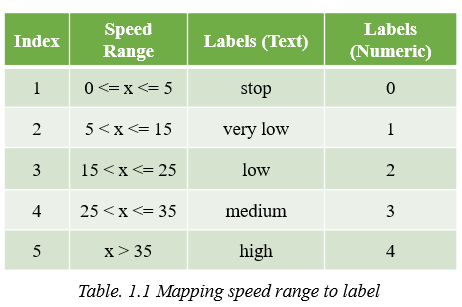

In [4]:
class2idx = {
    'stop':0,
    'very low':1,
    'low':2,
    'medium':3,
    'high':4
}

idx2class = {v: k for k, v in class2idx.items()}

df['labels'].replace(class2idx, inplace=True)

<AxesSubplot:xlabel='labels', ylabel='count'>

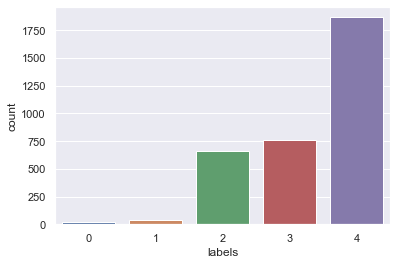

In [5]:
sns.countplot(x = 'labels', data=df)

### Splitting the data

The data collected has to be split into three groups namely,
1. Training Dataset
2. Testing Dataset
3. Validation Dataset

The train-test split procedure is used to estimate the performance of machine learning algorithms. It is a fast and easy procedure to perform which is used to make predictions on data not used to train the model. It can be used for classification or regression problems.

**1. Training Dataset**
- The sample of data used to fit the model
- The actual dataset that we use to train the model (weights and biases in the case of a Neural Network)
- The model sees and learns from this data

**2. Validation Dataset**
- The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters
- The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration
- The validation set is used to evaluate a given model, but this is for frequent evaluation

**3. Test Dataset**
- The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset
- The Test dataset provides the gold standard used to evaluate the model
- It is only used once a model is completely trained(using the train and validation sets)
- The test set is generally what is used to evaluate competing models 
- It contains carefully sampled data that spans the various classes that the model would face, when used in the real world


In order to split our data into train, validation, and test sets using train_test_split from Sklearn, we need to separate out our inputs and outputs. Input X is 'env'. Output y is 'labels'

In [6]:
X = df.iloc[:, 1]
y = df.iloc[:, 2]

### Making equal  distribution of data of all classes in all sets

Because there’s a class imbalance, we want to have equal distribution of all output classes in our train, validation, and test sets. To do that, we use the stratify option in function train_test_split().


In [7]:

# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)


TRAINING_SIZE = len(X_train)
VALIDATION_SIZE = len(X_val)
TEST_SIZE = len(X_test)

print('Total training images :',TRAINING_SIZE)
print('Total validation images :',VALIDATION_SIZE)
print('Total test images :',TEST_SIZE)

Total training images : 2410
Total validation images : 268
Total test images : 670


In [8]:
def get_class_distribution(obj):
    count_dict = {
        'stop':0,
    'very low':0,
    'low':0,
    'medium':0,
    'high':0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['stop'] += 1
        elif i == 1: 
            count_dict['very low'] += 1
        elif i == 2: 
            count_dict['low'] += 1
        elif i == 3: 
            count_dict['medium'] += 1
        elif i == 4: 
            count_dict['high'] += 1  
        else:
            pass
            
    return count_dict

### Class distribution in different sets

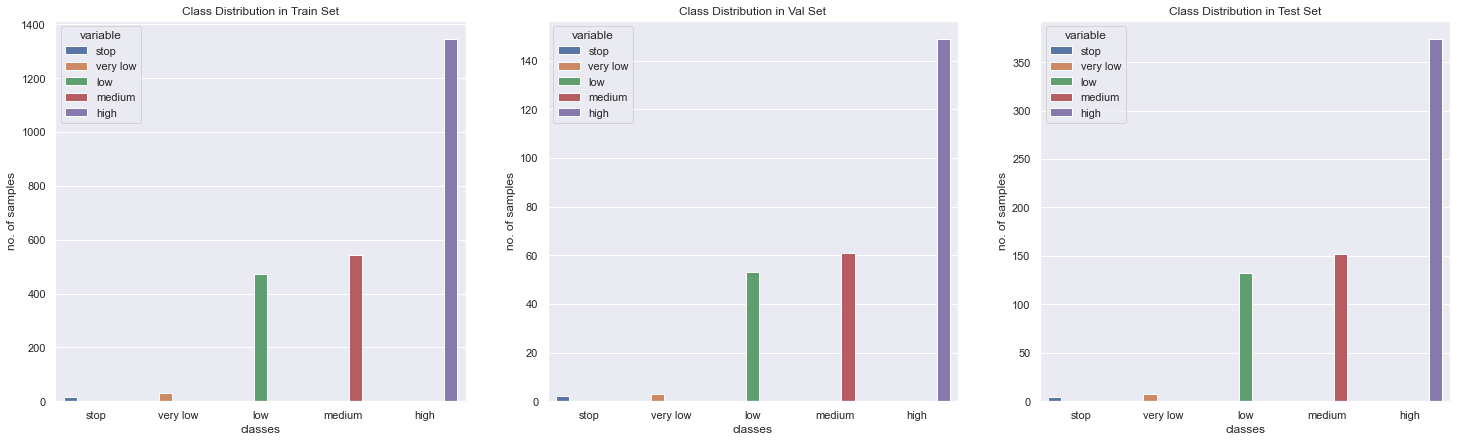

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))

# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set(xlabel="classes",ylabel="no. of samples",title='Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set(xlabel="classes",ylabel="no. of samples",title='Class Distribution in Val Set')

# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set(xlabel="classes",ylabel="no. of samples",title='Class Distribution in Test Set')
fig.savefig("results/split_data.png",dpi=400)


### Creating datasets,dataloaders and preprocessing the data

A lot of effort in solving any machine learning problem goes into preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make the code more readable.Creating a PyTorch Dataset and managing it with Dataloader keeps the data manageable and helps to simplify machine learning pipeline. A Dataset stores all the data, and Dataloader is can be used to iterate through the data, manage batches, transform the data, and much more.



### 3. Image pre-processing

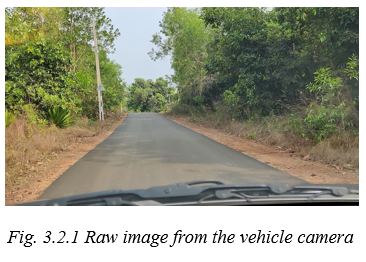



The aim of the preprocessing is to enhance the image features to avoid the distortion. Image preprocessing is very necessary aspect as the image should not have any impurities. The factors like noise and other aspects need to be eliminated. It is necessary for the preprocessing to remove noise.

Some of the steps were performed alredy on the images.
Those are,

**1. Windowing/Cropping**

Image cropping or Windowing is a technique that is used to select the most relevant areas of an image, discarding the useless ones. Handmade selection, especially in case of large photo collections, is a time consuming task. So we have used Automatic image cropping technique to extract the part of the image that was  most relevant, according to specific.


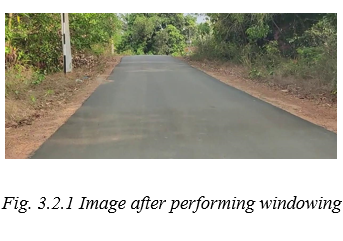

**2. Data size reduction**

The Gaussian pyramid was used to scale down the image to smaller size. It is a technique in image processing that breaks down an image into successively smaller groups of pixels to blur it. The "pyramid" is constructed by repeatedly calculating a weighted average of the neighboring pixels of a source image and scaling the image down.

Other pre-processings techniques which would be performed on the images are,


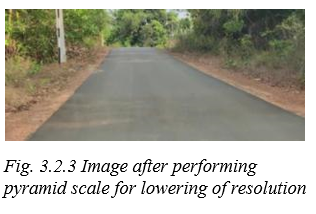


**1. Normalization**

Normalization is a data preparation technique that is frequently used in machine learning. The process of transforming the columns in a dataset to the same scale is referred to as normalization. It is required only when features of machine learning models have different ranges.The purpose of Normalization is to bring image to range that is normal to sense. The most widely used types of normalization in machine learning are,
1. Min-Max Scaling 
2. Standardization Scaling



Neural networks need data that lies between the range of (0,1). Among the best practices for training a Neural Network is to normalize the data to obtain a mean close to 0. Normalizing the data generally speeds up learning and leads to faster convergence.

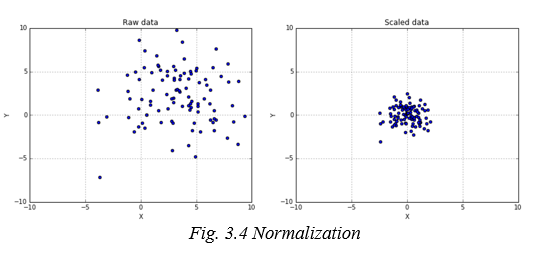

In [25]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data,train=False):
        self.X_data = np.array(X_data)
        self.y_data = np.array(y_data)
        self.train = train
        
    def __getitem__(self, index):
        path,target = self.X_data[index],self.y_data[index].astype(np.longlong)
        img = cv2.imread(path).astype(np.float32)
        
        #Changing color space from RGB to YUV
        #img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)

        #Applying Blur
        img = cv2.GaussianBlur(img,(5,5),0)

        #Resizing the image
        img = cv2.resize(img,(200,66))
        
        #Standardization of pixels
        img = (img / 255)
        
        return torch.from_numpy(img).float(), torch.tensor(target).long()
        
    def __len__ (self):
        return len(self.X_data)


### Datasets for training, validation and testing

In [26]:
train_dataset = ClassifierDataset(X_train,y_train,train=True)
val_dataset = ClassifierDataset(X_val,y_val)
test_dataset = ClassifierDataset(X_test, y_test)

### Creating weighted sampler


**Weighted Sampling**

Beacause of class imbalance in data, we use stratified split to create our train, validation, and test sets. While it helps, it still does not ensure that each mini-batch of our model see’s all our classes. We need to over-sample the classes with less number of values. To do that, we use the WeightedRandomSampler.

First, we obtain a list called target_list which contains all our outputs. This list is then converted to a tensor.

In [27]:
target_list = []
for t in y_train:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

Then, we obtain the count of all classes in our training set. We use the reciprocal of each count to obtain it’s weight. Now that we’ve calculated the weights for each class, we can proceed.

In [28]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0588, 0.0345, 0.0021, 0.0018, 0.0007])


In [29]:
class_weights_all = class_weights[target_list]


Finally initialize our WeightedRandomSampler

In [30]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

### Dataloaders


Data loading is an important component of any machine learning system. When we work with tiny datasets, we can get away with loading an entire dataset into GPU memory. With larger datasets, we must store examples in main memory. And when datasets grow too large to fit into main memory, data loading can become performance-critical. In designing a data loader, we aim to achieve more efficient data loading, to spend less effort on data preparation, and to present a clean and flexible interface. The goal is to load the data as quickly as possible. There are several heuristics we try to follow:
- Read continuously : We can read faster when reading from contiguous locations on disk.
- Reduce the bytes to be loaded : We can achieve this by storing data in a compact way, e.g. saving images in JPEG format. 
- Load and train in different threads : This avoids computational bottlenecks while loading data. 
- Save RAM : Judiciously decide whether to load entire files into RAM.

In [31]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_CLASSES = 5

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=len(val_dataset))
test_loader = DataLoader(dataset=test_dataset,batch_size=len(test_dataset))

# CNN Model

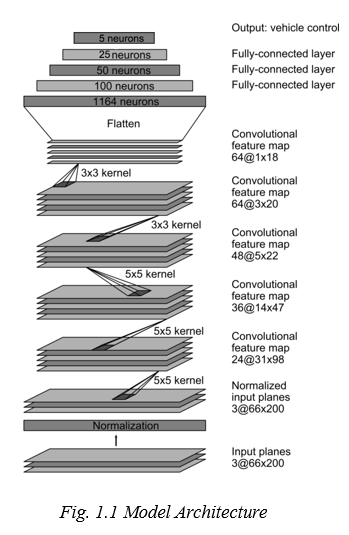

A Convolutional Neural Network, also known as CNN or ConvNet, is a class of neural networks that specializes in processing data that has a grid-like topology, such as an image. A digital image is a binary representation of visual data. It contains a series of pixels arranged in a grid-like fashion that contains pixel values to denote how bright and what color each pixel should be.

The human brain processes a huge amount of information the second we see an image. Each neuron works in its own receptive field and is connected to other neurons in a way that they cover the entire visual field. Just as each neuron responds to stimuli only in the restricted region of the visual field called the receptive field in the biological vision system, each neuron in a CNN processes data only in its receptive field as well. The layers are arranged in such a way so that they detect simpler patterns first (lines, curves, etc.) and more complex patterns (faces, objects, etc.) further along. By using a CNN, one can enable sight to computers.

A deep neural network combines multiple nonlinear processing layers, using simple elements operating in parallel and inspired by biological nervous systems. It consists of an input layer, several hidden layers, and an output layer. The layers are interconnected via nodes, or neurons, with each hidden layer using the output of the previous layer as its input



## Convolutional Neural Network Architecture
A CNN typically has two layers: a convolutional layer and a fully connected layer. The network architecture consists of 9 layers, including a normalization layer, 5 convolutional layers, and 4 fully connected layers. The convolutional layers are designed to perform feature extraction, and are chosen empirically through a series of experiments that vary layer configurations. We then use strided convolutions in the first three convolutional layers with a 2×2 stride and a 5×5 kernel, and a non-strided convolution with a 3×3 kernel size in the final two convolutional layers. Each layer is introduced with non-linearity with ReLU activation function and  the output layer consists of log SoftMax function for multi-class classification. The output will be any one of the range between 0-5, 5-15, 15-25, 25-35, more than 35


### Convolution Layer

The convolution layer is the core building block of the CNN. It carries the main portion of the network’s computational load.

This layer performs a dot product between two matrices, where one matrix is the set of learnable parameters otherwise known as a kernel, and the other matrix is the restricted portion of the receptive field. The kernel is spatially smaller than an image but is more in-depth. This means that, if the image is composed of three (RGB) channels, the kernel height and width will be spatially small, but the depth extends up to all three channels.

During the forward pass, the kernel slides across the height and width of the image-producing the image representation of that receptive region. This produces a two-dimensional representation of the image known as an activation map that gives the response of the kernel at each spatial position of the image. The sliding size of the kernel is called a stride.

If we have an input of size W x W x D and Dout number of kernels with a spatial size of F with stride S and amount of padding P, then the size of output volume can be determined by the following formula,

$H_{out}= [\frac{H + 2P - K}{S} ]+ 1 $

$W_{out}= [\frac{W + 2P - K}{S} ]+ 1 $


### Fully connected layers

Neurons in this layer have full connectivity with all neurons in the preceding and succeeding layer as seen in regular FCNN. This is why it can be computed as usual by a matrix multiplication followed by a bias effect.

The FC layer helps to map the representation between the input and the output.

Non-Linearity Layers
Since convolution is a linear operation and images are far from linear, non-linearity layers are often placed directly after the convolutional layer to introduce non-linearity to the activation map.

There are several types of non-linear operations, the popular ones being:

**1. Sigmoid**

The sigmoid non-linearity has the mathematical form σ(κ) = 1/(1+e¯κ). It takes a real-valued number and “squashes” it into a range between 0 and 1.

However, a very undesirable property of sigmoid is that when the activation is at either tail, the gradient becomes almost zero. If the local gradient becomes very small, then in backpropagation it will effectively “kill” the gradient. Also, if the data coming into the neuron is always positive, then the output of sigmoid will be either all positives or all negatives, resulting in a zig-zag dynamic of gradient updates for weight.

**2. Tanh**

Tanh squashes a real-valued number to the range [-1, 1]. Like sigmoid, the activation saturates, but — unlike the sigmoid neurons — its output is zero centered.

**3. ReLU**

The Rectified Linear Unit (ReLU) has become very popular in the last few years. It computes the function ƒ(κ)=max (0,κ). In other words, the activation is simply threshold at zero.

In comparison to sigmoid and tanh, ReLU is more reliable and accelerates the convergence by six times.

Unfortunately, a con is that ReLU can be fragile during training. A large gradient flowing through it can update it in such a way that the neuron will never get further updated. However, we can work with this by setting a proper learning rate.


### LOSS FUNCTION 

The loss function in a neural network quantifies the difference between the expected outcome and the outcome produced by the machine learning model. The loss function is used to derive the gradients which are used to update the weights. The average over all losses constitutes the cost. Some of the loss functions in-clude, 
- Mean Squared Error (MSE) 
- Binary Cross entropy (BCE) 
- Categorical Cross entropy (CC) 
- Sparse Categorical Cross entropy (SCC) 


Cross-entropy-based loss functions are commonly used in classification scenarios where as MSE is used for regression scenarios. Cross entropy is a measure of the difference between two probability distributions. In a machine learning maximum likelihood estimation is used to calculate the difference between the probability distribution produced by the data generating process (the expected outcome) and the distribution represented by our model of that process. The resulting difference produced is called the loss. It increases exponentially as the prediction diverges from the actual outcome. If the actual outcome is 1, the model should produce a probability estimate that is as close as possible to 1 to reduce the loss as much as possible.




### OPTIMIZATION ALGORITHM 

An optimizer is a function or an algorithm that modifies the attributes of the neural network, such as weights and learning rate. Thus, it helps in reducing the overall loss and improve the accuracy. The problem of choosing the right weights for the model is a daunting task, as a deep learning model generally consists of millions of parameters. It raises the need to choose a suitable optimization algorithm for particular application. The terms related to the optimization process include, 

1. Epoch – The number of times the algorithm runs on the whole training dataset. 
2. Sample – A single row of a dataset. 
3. Batch – It denotes the number of samples to be taken to for updating the model parameters. 
4. Learning rate – It is a parameter that provides the model a scale of how much model weights should be updated. 
5. Cost Function/Loss Function – A cost function is used to calculate the cost that is the difference between the predicted value and the actual value. 
6. Weights/ Bias – The learnable parameters in a model that controls the signal between two neurons. 


The main optimization algorithms are, 
- Gradient Descent 
- Stochastic Gradient Descent 
- Adam etc. 

The optimization algorithm used here is Adam. Adam optimization algo-rithm is an extension to stochastic gradient descent that has recently seen broad-er adoption for deep learning applications in computer vision and natural language processing. Straightforward to implement, computationally efficient, little memory requirements, well suited for problems that are large in terms of data and/or pa-rameters, hyper-parameters have intuitive interpretation and typically require little tuning. Adam as combining the advantages of AdaGrad that maintains a per-parameter learning rate that improves performance on problems with sparse gra-dients and RMSProp that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the. This means the algorithm does well on online and non-stationary problems. 



In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # [(W−K+2P)/S] + 1
        # size =2,stride = 2 (shift kernal to 2px)
        # W is the input volume(),K is the Kernel size(5),P is the padding (0),S is the stride (2)
        # input_shape = (66,200,3)
        self.conv1 = nn.Conv2d(3,24,kernel_size=(5,5),stride=(2,2)) #O/p 31*98*24
        self.conv2 = nn.Conv2d(24,36,kernel_size=(5,5),stride=(2,2)) #O/p 14*47*36
        self.conv3 = nn.Conv2d(36,48,kernel_size=(5,5),stride=(2,2)) #O/p 5*22*48
        self.conv4= nn.Conv2d(48,64,kernel_size=(3,3),stride=(1,1)) #O/p 3*20*64
        self.conv5 = nn.Conv2d(64,64,kernel_size=(3,3),stride=(1,1)) #O/p 1*18*64
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(18*64,100) # Flattening -> 1*18*64
        self.fc2 = nn.Linear(100,50)
        self.fc3 = nn.Linear(50,25)
        self.fc4 = nn.Linear(25,5)

    def config_model(self,num_iterations,num_epocs=4,batch_size=10,learning_rate=0.0001):
        #Model Hyperparameters
        self.num_epocs = num_epocs
        self.batch_size = batch_size
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.parameters(),lr=self.learning_rate)

        print("#"*100)
        print('***************** Model hyperparameters ********************\n')
        print(f"\t\t\tNo. Iterations     : {self.num_iterations}\n\
                        No. epocs     : {self.num_epocs}\n\
                        Batch Size    : {self.batch_size}\n\
                        Learning Rate : {self.learning_rate}\n\
                        Loss Function : Cross Entropy Loss\n\
                        Optimizer     : Adam Optimizer\n ")
        print("#"*100)

    def forward(self,x):
        # From: [batch_size, height, width, channels]
        # To: [batch_size, depth/channels, height, width]
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x)) # First convolution layer
        x = self.relu(self.conv2(x)) # Second convolution layer
        x = self.relu(self.conv3(x)) # Third convolution layer
        x = self.relu(self.conv4(x)) # Fourth convolution layer
        x = self.relu(self.conv5(x)) # Fifth convolution layer
        x = x.reshape(-1,18*64)  # Flattening
        x = self.relu(self.fc1(x))  # Firts FCL
        x = self.relu(self.fc2(x))  # Second FCL
        x = self.relu(self.fc3(x))  # Third FCL
        x = self.fc4(x)  # Fourth FCL
        
        return x

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

CNN(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (fc1): Linear(in_features=1152, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=5, bias=True)
)


In [34]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
def accuracy(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

def train(model,train_loader):
    print("Training the model...")
    for e in tqdm(range(1, EPOCHS+1)):

        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()

            y_train_pred = model(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = accuracy(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()


        # VALIDATION    
        with torch.no_grad():

            val_epoch_loss = 0
            val_epoch_acc = 0

            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                y_val_pred = model(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = accuracy(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
        
    print('Training finished!')
    
    ### Plotting the results
    pd.DataFrame(accuracy_stats).to_csv("accuracy.csv")
    pd.DataFrame(loss_stats).to_csv("loss.csv")

    loss_data = pd.read_csv("loss.csv",index_col=0)
    acc_data = pd.read_csv("accuracy.csv",index_col=0)

    plt.plot(np.arange(1,EPOCHS+1),loss_data['train'],label='Training Loss')
    plt.plot(np.arange(1,EPOCHS+1),loss_data['val'],label='Validation Loss')
    plt.title("Plot of Loss vs No. of Epochs")
    plt.xlabel("No. of Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("results/loss.png",dpi=200)
    plt.show()

    plt.plot(np.arange(1,EPOCHS+1),acc_data['train'],label='Training Accuracy')
    plt.plot(np.arange(1,EPOCHS+1),acc_data['val'],label='Validation Accuracy')
    plt.title("Plot of Accuracy vs No. of Epochs")
    plt.xlabel("No. of Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig("results/accuracy.png",dpi=200)
    plt.show()
    
    
#Saving model parameters
def save(model,optimizer,file_path='trained_model/model.pth'):
    print('Saving the model...')
    torch.save({
        'state_dict':model.state_dict(),
        'optimizer':optimizer.state_dict()
    },file_path)
    print('Model saved sucessfully.')

#Loading the model parameters
def load(model,optimizer=None,path='trained_model/model.pth'):
    if os.path.isfile(path):
        print('Loading model parameters...')
        #Loading the existing brain
        brain = torch.load(path)
        model.load_state_dict(brain['state_dict'])
        
        
        if optimizer:
            optimizer.load_state_dict(brain['optimizer'])
        else:
            print('No optimizer found! Skipping the optimizer weights...')
        print('Model parameters loaded sucessfully.')
def test(model,test_data_loader):
    with torch.no_grad():
        for X, y in test_data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_acc = accuracy(y_pred, y)

            print(f'Model Accuracy for testing :{test_acc:.3f}')
            
            #Evaluation
            y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
            
            y = y.to('cpu').numpy()
            y_pred_tags = y_pred_tags.to('cpu').numpy()
            
            cm = confusion_matrix(y,y_pred_tags)

            #Analyzing the results through heat map
            plot = sns.heatmap(cm,annot=True,fmt='d')
            plot.set_title('Confusion Matrix')
            plot.figure.savefig("results/test_cm.png",dpi=400)

            print(classification_report(y,y_pred_tags))

### Training the model

Model training in machine language is the process of feeding an ML algorithm with data to help identify and learn good values for all attributes involved. This iterative process is called “model fitting”. The accuracy of the training dataset or the validation dataset is critical for the precision of the model. There are several types of machine learning models, of which the most common ones are supervised and unsupervised learning. Supervised learning is possible when the training data contains both the input and output values. Unsupervised learning involves determining patterns in the data. There are a few definitions related to this section are:

1.	Parameter 
   A model parameter is a configuration variable that is internal to the model and whose value can be estimated from data. They are required by the model when making predictions. They are estimated or learned from data 
2.	Hyperparameter
   A model hyperparameter is a configuration that is external to the model and whose value cannot be estimated from data. They are often used in processes to help estimate model parameters. They are often specified by the practitioner. They are often tuned for a given predictive modeling problem. 


In [35]:
#train(model,train_loader)


The plot of the variation of the training loss with the epoch is shown below. The variation of train accuracy and validation accuracy was also plotted against 
number of epochs. At the beginning the training loss and validation loss were high. As the model was introduced with more and more training samples and the number of epochs increases the training loss got reduced along with the validation. The min loss was about 0.03 and the train accuracy was 99%. The validation loss was 0.55 and the validation accuracy was 89%. After epoch 100, the model was come to saturation, after which the testing accuracy remained the same and the validation loss started fluctuating.


Hyperparameters Used:
- Batch size: 16 
- Number of epochs: 300 
- Learning rate: 0.0007 


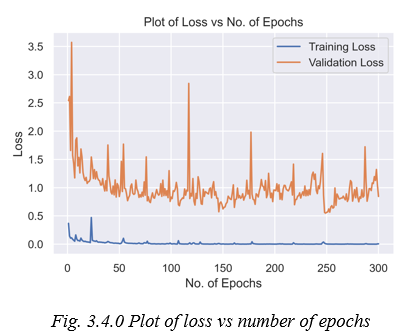

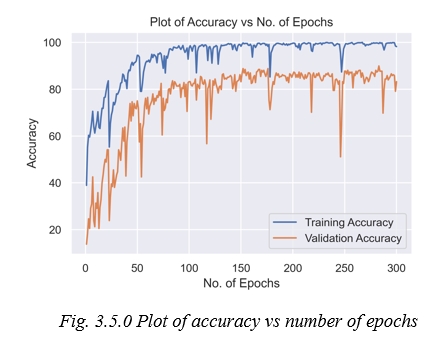

### Saving the model



In [36]:
#save(model,optimizer)

### Loading the model

In [37]:
load(model)

Loading model parameters...
No optimizer found! Skipping the optimizer weights...
Model parameters loaded sucessfully.


### Testing the model

Model testing is referred to as the process where the performance of a fully trained model is evaluated on a testing set. The testing set consisting of a set of testing samples should be separated from the both training and validation sets but it should follow the same probability distribution as the training set. Model testing involves explicit checks for behaviors that we expect our model to follow. The testing was done on the test images and the test accuracy was about 86%. The confusion matrix for the test results is shown below and the model is evaluated based on that results.

Model Accuracy for testing :86.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.67      0.75      0.71         8
           2       0.78      0.77      0.78       132
           3       0.76      0.89      0.82       152
           4       0.95      0.88      0.91       374

    accuracy                           0.86       670
   macro avg       0.83      0.86      0.84       670
weighted avg       0.87      0.86      0.86       670



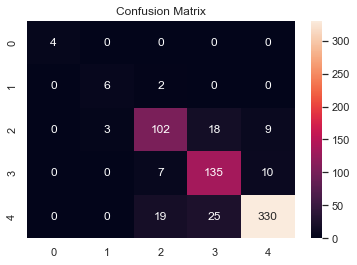

In [38]:
test(model,test_loader)